# do the users differ from non users?

does the captured behaviour data of amazon users differ in any way from the non-users? 

one way to answer that question is to do statistical t-test on each variable assuming normal distribution. you'd get the result that some do, some don't. we need to apply corrections (e.g. bonferroni) and make sure not to fool ourselves. much it gets left to interpretation. 

another tactic is to visualise the groupings in different colour and try to spot a difference in how they are distributed. since we are talking about multi-dimensional feature space, we first need a dimensionality reduction tecnique. three spring to mind

- PCA, the linear algebra way
- t-SNE, stochastic nearest neighbours
- UMAP, a more modern approach, which has worked well for me in the past

In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns
from   sklearn.compose       import ColumnTransformer
from   sklearn.decomposition import PCA
from   sklearn.manifold      import TSNE
from   sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import umap

In [9]:
DATABASE_FILEPATH='../data/prime.ddb'
with duckdb.connect(DATABASE_FILEPATH) as con:
    df=(
        con.sql("SELECT * FROM user_summary")
        .df()
        .drop(
            columns=[
                'user_id',                ## no bearing on user properties
                'num_apps',               ## uniformly 1, only 'chrome'
                'num_countries',          ## only 1 per user_id
                'num_genders',            ## only 1 gender per user_id
                'num_age_groups',         ## only one age group per user_id
                'earliest_event',         ## ignore timestamp data
                'latest_event',           ## ignore timestamp data
                'all_searches_combined',  ## do more nlp later
                'country',                ## uniformly 'US'
                'the_age_group'           ## replaced with age_bracket_start (numerical)
            ]
        )
    )

In [10]:
# check the feature dimensions
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   is_amazon_user      993 non-null    bool    
 1   num_events          993 non-null    int64   
 2   num_event_types     993 non-null    int64   
 3   num_domains         993 non-null    int64   
 4   range_active_days   993 non-null    int64   
 5   num_dates_active    993 non-null    int64   
 6   prop_top_domains    993 non-null    float32 
 7   prop_rare_domains   993 non-null    float32 
 8   prop_search_events  993 non-null    float32 
 9   the_gender          993 non-null    category
 10  age_bracket_start   993 non-null    int32   
dtypes: bool(1), category(1), float32(3), int32(1), int64(5)
memory usage: 56.6 KB


In [12]:
# separate features from target
X = df.drop('is_amazon_user', axis=1)  # features only
y = df['is_amazon_user']

# identify and separate out numerical and categorical columns
numerical_features = X.select_dtypes(include=['int32', 'int64', 'float64', 'bool']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist() 
print(f"numerical features: {numerical_features}")
print(f"categorical features: {categorical_features}")


# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# transform the data in scaled 
X_scaled = preprocessor.fit_transform(X)

numerical features: ['num_events', 'num_event_types', 'num_domains', 'range_active_days', 'num_dates_active', 'age_bracket_start']
categorical features: ['the_gender']


feature_names: ['num_events', 'num_event_types', 'num_domains', 'range_active_days', 'num_dates_active', 'age_bracket_start', 'the_gender_male', 'the_gender_non_binary', 'the_gender_other']


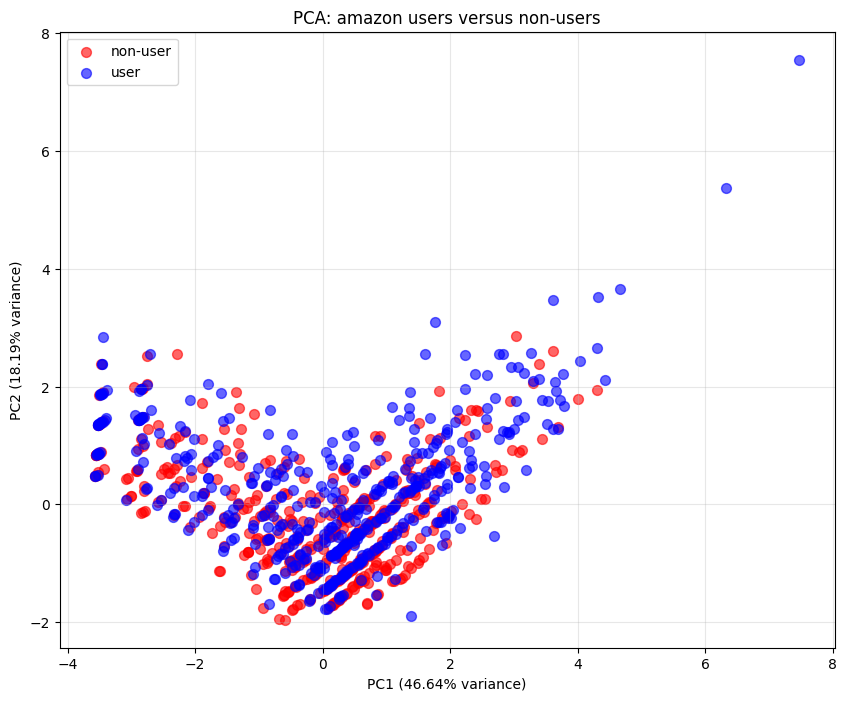

feature contributions:
                            PC1       PC2
num_events             0.403094  0.489171
num_event_types        0.382799  0.042989
num_domains            0.470798  0.356733
range_active_days      0.470290 -0.435965
num_dates_active       0.496591 -0.384575
age_bracket_start      0.026182  0.541648
the_gender_male        0.025880  0.008942
the_gender_non_binary  0.005651 -0.012058
the_gender_other       0.012873  0.005810


In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# visualisation
plt.figure(figsize=(10, 8))
colors = ['red', 'blue']
labels = ['non-user', 'user']

feature_names = numerical_features
for col in categorical_features:
    unique_values = X[col].unique()
    # one hot encoder drops first category
    for val in sorted(unique_values)[1:]:
        feature_names.append(f"{col}_{val}")
     
print(f"feature_names: {feature_names}")


for i, (color, label) in enumerate(zip(colors, labels)):
    mask = y == bool(i)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=color, label=label, alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA: amazon users versus non-users')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# feature contributions
# feature_names = X.columns
pca_components = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_names
)
print("feature contributions:")
print(pca_components)

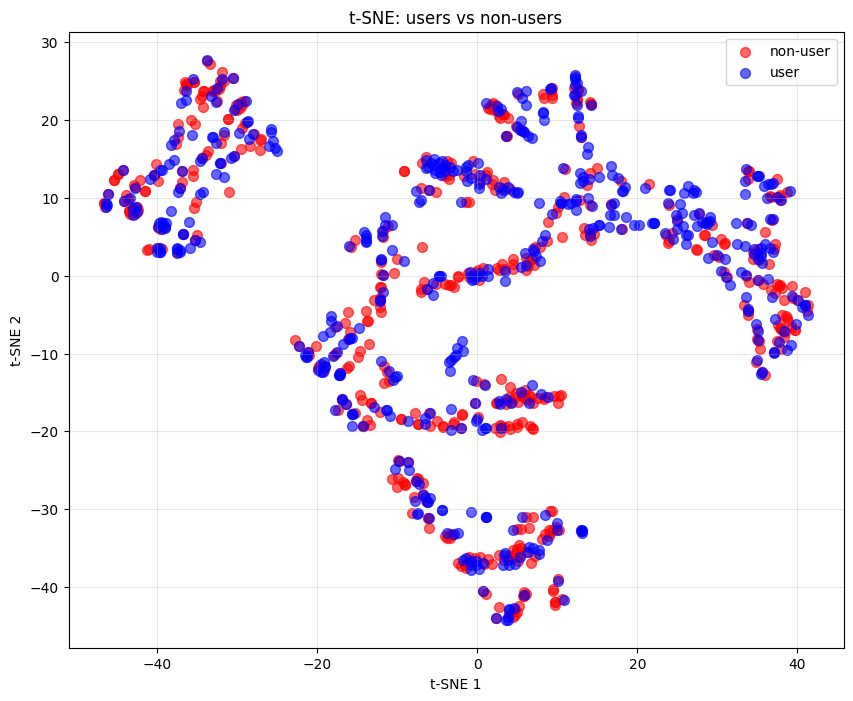

In [14]:
# try t-sne instead
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Visualize
plt.figure(figsize=(10, 8))
for i, (color, label) in enumerate(zip(colors, labels)):
    mask = y == bool(i)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
               c=color, label=label, alpha=0.6, s=50)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE: users vs non-users')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


/Users/oh/study/prime_day_analysis/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/oh/study/prime_day_analysis/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


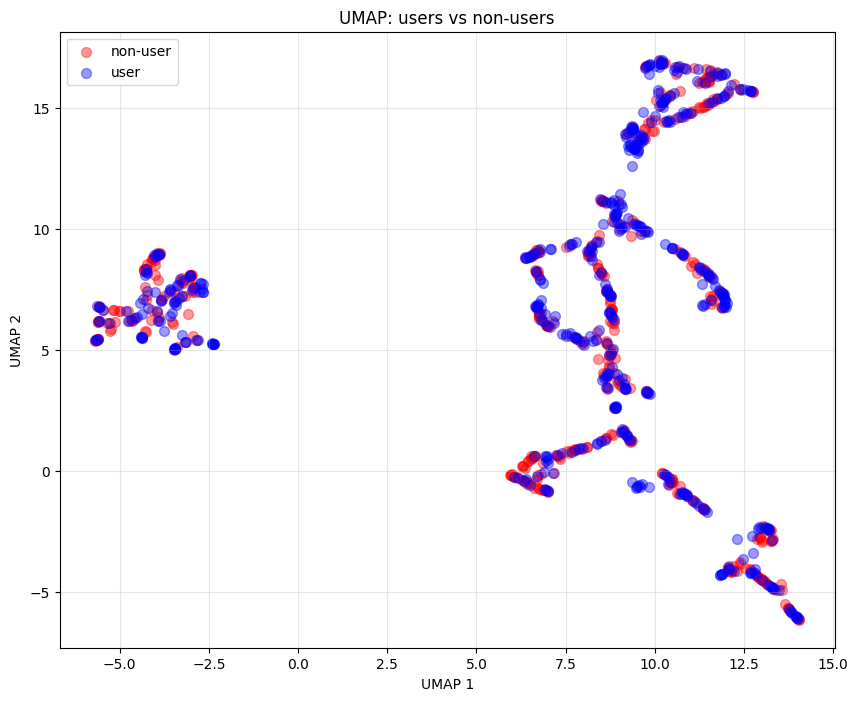

In [15]:
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
for i, (color, label) in enumerate(zip(colors, labels)):
    mask = y == bool(i)
    plt.scatter(
        X_umap[mask, 0],
        X_umap[mask, 1],
        c=color,
        label=label,
        alpha=0.4,
        s=50
    )

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP: users vs non-users')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# conclusion 

considering these features alone there is nothing to indicates that the population of users behave differently online from the population of non-users. 

any such signal may yet be found in the types of sites (domains) they visit, or the contents of their search terms. but these overview metrics and counts do not surface such differences. 